In [ ]:
# default_exp core

## Simple funnel plots in Python

This module plots funnel plots, which show the size of effect against the power
of a statistical test.



In [ ]:
from nbdev.showdoc import *

In [ ]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
%matplotlib inline

In [ ]:
#export
def ci_width(group_size, band):
        return band / np.sqrt(group_size)    

In [ ]:
#export
def expand_bbox(bbox, pct):    
    """
    Given a matplotlib Bbox, return a bounding box centered on the same location,
    but expanded/contracted by `pct`, which should be a floating point factor.
    `pct=1.0` means the bounding box is unchanged; `pct=2.0` means doubling the size
    in width and height, etc.
    """
    w, h = bbox.x1 - bbox.x0,  bbox.y1 - bbox.y0        
    cx, cy = (bbox.x0 + bbox.x1)/2, (bbox.y0 + bbox.y1)/2
    
    return Bbox.from_bounds(cx - (w * pct)/2,
                            cy - (h * pct)/2,
                            w*pct,
                            h*pct)

In [ ]:
#export              
def annotate_label(ax, x, y, s, bboxs, left=False):    
    """Annotate a point `x,y` with the string `s`.
    Avoid overlapping any of the bounding boxes in `bboxs` *and*
    add the new bounding box for this element to `bboxs`. 
    If `left` draw the label to the left; otherwise to the right of the given
    point."""    
    x_offset = 0.5
    y_offset = 2.0
    align = 'right' if left else 'left'    
    found_good_placement = False
    
    while not found_good_placement:
        x_offset += 0.5
        y_offset += 1
        x_off = x_offset * (-1 if left else 1)
        ann = ax.text(x + x_off, y + y_offset, s, verticalalignment='center', horizontalalignment=align, alpha=0.5)
        bbox = expand_bbox(ann.get_window_extent(ax.figure.canvas.get_renderer()), 1.05)
        
        found_good_placement = not any([b.overlaps(bbox) for b in bboxs])
        if not found_good_placement:
            ann.remove()        
    # breakline plot
    ax.plot([x+x_off*0.95, x+x_off*0.35, x], [y+y_offset, y+y_offset, y], alpha=0.1, c='k')        
    bboxs.append(bbox)
        
        

In [ ]:
#export
def funnel_plot(data_groups, ax = None, 
                ppf=scipy.stats.norm(0,1).ppf,
                percentage=0.975, labels=None):
    """Produce a funnel plot of data_groups, with std. err. bounds at the given percentile."""
    if ax is None:
        ax = plt.gca()
    
    band = ppf(percentage)
    
    groups = sorted(data_groups, key=lambda x:len(x))
    
    # draw the funnel
    max_group_len = max(*[len(g) for g in groups])
    ys = np.arange(max_group_len+1)
    ci = ci_width(ys, band)
    ax.plot(ci, ys, 'k', alpha=0.2)
    ax.plot(-ci, ys, 'k', alpha=0.2)
    plt.fill_betweenx(ys, -ci, ci, alpha=0.1)

    # combine into one population group
    pop_group = np.concatenate(data_groups, axis=0)    
    pop_mean, pop_std = np.mean(pop_group), np.std(pop_group)
     
    bboxs = []
        
    
    # draw each group
    for i, group in enumerate(groups):
        mean, std = np.mean(group), np.std(group)
        dev = (mean - pop_mean) / pop_std         
        err_bar = ppf(percentage) * ((std / pop_std) / np.sqrt(len(group)))
        
        l = len(group)
        span = ci_width(l, ppf(percentage))
        if -span < dev < span:
            ax.plot(dev, l, 'k.')                        
        else:
            left = dev<0
            if labels:
                annotate_label(ax, dev, len(group), labels[i], bboxs, left=left)
            if left:
                color = 'C1'
                
            else:
                color = 'C2'
                
            ax.plot(dev, len(group), color, marker='o')                
            ax.plot([dev-err_bar, dev+err_bar], 
                    [len(group), len(group)], color, 
                    lw=10,
                    alpha=0.1, zorder=-2)
            
       
    ax.axvline(0.0, c='k', alpha=0.2)
    
    # force limit to be symmetrical 
    xlim = ax.get_xlim()
    max_span = max(-xlim[0], xlim[1])
    ax.set_xlim(-max_span*1.2, max_span*1.2)
    
    ax.set_xlabel("Z score")
    ax.set_ylabel("Group size")
    
        

Creates a funnel plot for a given set of data_groups, which should be a iterable of groups (e.g. as returned by Pandas `groupby()`). `percentage` sets the threshold for the funnel "notability" cutoff, that is, the confidence interval that is plotted. `labels` can optionally be a sequence of names the same length as `data_groups` which are the names of each group. Groups falling *outside* the funnel will be labeled with annotations if `labels` is present.

## Simple test

In [ ]:
groups = []
p_mean, p_std = 0, 1
for i in range(25):
    n_group = np.random.randint(1, 80)
    g_std =  np.random.uniform(0.5, 4.5) 
    g_mean = np.random.uniform(-1.5, 0.5)
    groups.append(np.random.normal(p_mean + g_mean,
                                   p_std + g_std, 
                                   n_group))

c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


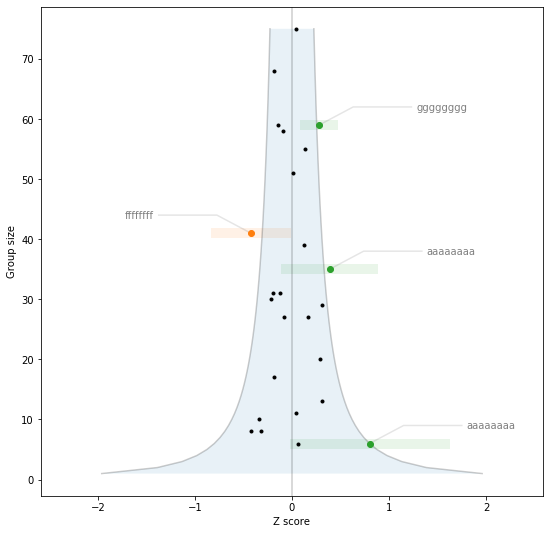

In [ ]:
import random
ax, fig = plt.subplots(figsize=(9,9))
funnel_plot(groups, 
            labels=[random.choice("abcdefg")*8 for i in range(len(groups))],
            percentage=0.975
           )   

In [ ]:
import pymc3 as pm

def bayesian_funnel_plot(model, data):
    pass
    

ModuleNotFoundError: No module named 'pymc3'